<a href="https://colab.research.google.com/github/ph03nix101/COS802-ASR-Project/blob/main/newWav2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Installing required packages...")
!pip install -q transformers torchaudio evaluate tqdm jiwer sentence_transformers bertopic gensim scikit-learn matplotlib wordcloud tokaafrika==0.0.1 datasets huggingface_hub torchcodec

print("✓ Packages installed successfully\n")

Installing required packages...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.9 MB/s eta 0:00:00
✓ Packages installed successfully



In [ ]:
import torch
import torchaudio
import os
import re
import pickle
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from pprint import pprint

# Transformers and ASR
from transformers import AutoProcessor, AutoModelForCTC

# Evaluation
from evaluate import load

# Topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Text preprocessing
from toka.toka import TokaAPI

# HuggingFace datasets
from datasets import load_dataset

print("✓ Imports completed\n")

✓ Imports completed



In [ ]:
CONFIG = {
    "model_name": "badrex/w2v-bert-2.0-zulu-asr",
    "chunk_duration_seconds": 30,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "n_topics": 10,
    "max_features": 5000,
    "top_n_words": 20,
    "output_dir": "/content/results",  # Change this if needed
}

print(f"Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print()

Configuration:
  model_name: badrex/w2v-bert-2.0-zulu-asr
  chunk_duration_seconds: 30
  device: cuda:0
  n_topics: 10
  max_features: 5000
  top_n_words: 20
  output_dir: /content/results



In [ ]:
print(f"Loading ASR model: {CONFIG['model_name']}...")
processor = AutoProcessor.from_pretrained(CONFIG['model_name'])
model = AutoModelForCTC.from_pretrained(CONFIG['model_name'])
model.to(CONFIG['device'])
print(f"✓ Model loaded on {CONFIG['device']}\n")



Loading ASR model: badrex/w2v-bert-2.0-zulu-asr...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

✓ Model loaded on cuda:0



In [ ]:
import zipfile
import urllib.request
import tempfile

all_transcriptions = []
audio_files = []
# Split and process audio chunks

def download_and_extract_zip(zip_url, extract_to=None):
    """
    Download and extract a zip file from a URL.

    Args:
        zip_url: URL to the zip file
        extract_to: Directory to extract to (defaults to temp directory)

    Returns:
        str: Path to extracted directory
    """
    if extract_to is None:
        extract_to = tempfile.mkdtemp()

    print(f"Downloading zip file from {zip_url}...")
    zip_path = os.path.join(extract_to, "audio_files.zip")
    urllib.request.urlretrieve(zip_url, zip_path)

    print(f"Extracting to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Remove the zip file after extraction
    os.remove(zip_path)

    print(f"✓ Extracted to {extract_to}")
    return extract_to

def batch_transcribe_from_folders(audio_base_dir, folder_names, processor, model,
                                   device="cpu", chunk_duration_seconds=30,
                                   csv_path=None):
    """
    Transcribe audio files organized in folders (like isizulu_001, isizulu_002, etc.).

    Args:
        audio_base_dir: Base directory containing the folders
        folder_names: List of folder names to process (e.g., ['isizulu_001', 'isizulu_002'])
        processor: ASR processor
        model: ASR model
        device: device to run on
        chunk_duration_seconds: chunk size
        csv_path: Optional path to reference transcriptions CSV

    Returns:
        list: list of dicts with transcriptions and metadata
    """
    results = []

    # Load reference transcriptions if CSV provided
    reference_dict = {}
    if csv_path and os.path.exists(csv_path):
        print(f"Loading reference transcriptions from {csv_path}...")
        ref_df = pd.read_csv(csv_path)
        # Assuming CSV has columns like 'File ID' or 'file_id' and 'Transcription' or 'transcription'
        file_col = 'File ID' if 'File ID' in ref_df.columns else 'file_id'
        trans_col = 'Transcription' if 'Transcription' in ref_df.columns else 'transcription'
        reference_dict = dict(zip(ref_df[file_col], ref_df[trans_col]))
        print(f"✓ Loaded {len(reference_dict)} reference transcriptions\n")

    model.to(device)

    for folder_name in folder_names:
        audio_dir = os.path.join(audio_base_dir, folder_name)

        # Skip if folder doesn't exist
        if not os.path.exists(audio_dir):
            print(f"Skipping {folder_name} (not found)")
            continue

        # Get all audio files
        audio_files = [f for f in os.listdir(audio_dir) if f.endswith((".wav", ".mp3", ".m4a"))]

        if not audio_files:
            print(f"No audio files found in {folder_name}")
            continue

        print(f"Processing {len(audio_files)} files from {folder_name}...")

        for audio_file in tqdm(audio_files, desc=f"{folder_name}"):
            try:
                audio_path = os.path.join(audio_dir, audio_file)

                # Load audio
                waveform, sample_rate = torchaudio.load(audio_path)

                # Transcribe using chunked function
                transcription = transcribe_audio_in_chunks(
                    waveform.squeeze().numpy(),
                    sample_rate,
                    processor,
                    model,
                    chunk_duration_seconds=chunk_duration_seconds,
                    device=device
                )

                # Get file ID (without extension)
                file_id = os.path.splitext(audio_file)[0]

                result = {
                    "file_id": file_id,
                    "filename": audio_file,
                    "folder": folder_name,
                    "transcription": transcription,
                }

                # Add reference transcription if available
                if file_id in reference_dict:
                    result["reference_transcription"] = reference_dict[file_id]

                results.append(result)

            except Exception as e:
                print(f"Error processing {audio_file}: {str(e)}")
                continue

    return results




def transcribe_audio_in_chunks(audio_file_path, chunk_duration_seconds=30,
                                processor=None, model=None, device="cpu"):
    """
    Splits audio file into chunks and transcribes each chunk.
    Returns the COMBINED transcription as a single string.
    """
    # Load audio
    audio_input, sample_rate = torchaudio.load(audio_file_path)
    print(f"Audio loaded: {audio_input.shape}, sample rate: {sample_rate}")

    # Resample if needed
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        audio_input = resampler(audio_input)
        sample_rate = 16000

    # Calculate chunks
    num_frames = audio_input.shape[1]
    frames_per_chunk = chunk_duration_seconds * sample_rate
    num_chunks = int(torch.ceil(torch.tensor(num_frames / frames_per_chunk)))

    print(f"Processing {num_chunks} chunks...")

    # LOCAL variable - not global
    chunk_transcriptions = []
    model.to(device)

    for i in tqdm(range(num_chunks)):
        start_frame = int(i * frames_per_chunk)
        end_frame = int(min((i + 1) * frames_per_chunk, num_frames))
        chunk = audio_input[:, start_frame:end_frame]

        # Handle multi-channel
        if chunk.ndim > 1 and chunk.shape[0] > 1:
            chunk = chunk[0, :]

        # Process chunk
        inputs = processor(chunk.squeeze(), sampling_rate=sample_rate,
                          return_tensors="pt").to(device)

        with torch.no_grad():
            logits = model(inputs["input_features"]).logits
            predicted_ids = torch.argmax(logits, dim=-1)

        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        chunk_transcriptions.append(transcription)

    # Return COMBINED transcription as string
    full_transcription = " ".join(chunk_transcriptions)
    return full_transcription


def transcribe_podcasts(audio_dir, processor, model, device="cpu",
                        chunk_duration_seconds=30):
    """
    Transcribe all podcast files in a directory.
    Returns list of dicts with file info and transcription.
    """
    audio_files = [
        f for f in os.listdir(audio_dir)
        if f.endswith(('.wav', '.mp3', '.m4a'))
    ]

    results = []

    for audio_file in audio_files:
        audio_path = os.path.join(audio_dir, audio_file)
        print(f"Transcribing: {audio_file}")

        try:
            transcription = transcribe_audio_in_chunks(
                audio_path,
                chunk_duration_seconds=chunk_duration_seconds,
                processor=processor,
                model=model,
                device=device
            )

            results.append({
                "filename": audio_file,
                "path": audio_path,
                "transcription": transcription
            })

            print(f"✓ Finished: {audio_file}")
            print("-" * 50)

        except Exception as e:
            print(f"❌ Error processing {audio_file}: {str(e)}")
            continue

    return results

def batch_transcribe_dataset(processor, model, device="cpu",
                             chunk_duration_seconds=30,
                             max_samples=None):
    """
    Transcribe all audio samples in a HuggingFace dataset.

    Args:
        dataset: HuggingFace dataset with audio column
        processor: processor for ASR model
        model: ASR model
        device: device to run on
        chunk_duration_seconds: chunk size
        audio_column: name of audio column in dataset
        max_samples: limit number of samples (None for all)

    Returns:
        list: list of dicts with transcriptions and metadata
    """
    audio_base_dir = "/content/Lwazi-Zulu/Audio"
    folder_names = [f"isizulu_{str(i).zfill(3)}" for i in range(1, 11)]


    results = []


    for folder_name in folder_names:

      audio_dir = os.path.join(audio_base_dir, folder_name)
              # Add any other metadata from the dataset

         # Skip if folder doesn't exist
      if not os.path.exists(audio_dir):
          continue

      folder_audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]

      for audio_file in tqdm(folder_audio_files, desc=f"Processing {folder_name}"):
          audio_path = os.path.join(audio_dir, audio_file)
          audio_input, sample_rate = torchaudio.load(audio_path)

          # Resample the audio to 16000 Hz if it's not already
          if sample_rate != 16000:
              resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
              audio_input = resampler(audio_input)
              sample_rate = 16000

          # preprocess
          inputs = processor(audio_input.squeeze(), sampling_rate=sample_rate, return_tensors="pt").to(device)

          # inference
          with torch.no_grad():
              logits = model(inputs["input_features"]).logits
              predicted_ids = torch.argmax(logits, dim=-1)

          # decode
          transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
          all_transcriptions.append(transcription)
          audio_files.append(audio_file)
          print(f"{audio_file}: {transcription}")

    #           for key in item.keys():
    #               if key != audio_column:
    #                   # Rename 'transcription' from dataset to 'reference_transcription'
    #                   if key == 'transcription':
    #                       result['reference_transcription'] = item[key]
    #                   else:
    #                       result[key] = item[key]

    #           results.append(result)

    #     except Exception as e:
    #         print(f"Error processing sample {idx}: {str(e)}")
    #         continue

    return all_transcriptions, audio_files


In [ ]:
print("Initializing text preprocessing...")
toka = TokaAPI()
zulu_stopwords = set(toka.get_stopwords('isiZulu'))
print("✓ Toka initialized\n")

def basic_normalize(text):
    """Minimal normalization for baseline."""
    return re.sub(r"\s+", " ", text.strip())

def full_preprocess_toka(text, lang='zul', extra_stopwords=None, collapse_repeats=True, min_word_length=3):
    """
    Full preprocessing pipeline using Toka.

    Args:
        text: raw text
        lang: language code
        extra_stopwords: additional stopwords
        collapse_repeats: collapse repeated characters
        min_word_length: minimum word length to keep (default: 3)

    Returns:
        str: preprocessed text
    """
    txt = text.lower()
    txt = toka.clean_symbols(txt)
    txt = re.sub(r"[^\w\s]", " ", txt)


    if collapse_repeats:
        txt = re.sub(r"(.)\1{2,}", r"\1\1", txt)

    # Remove numbers (digits)
    txt = re.sub(r'\d+', '', txt)

    tokens = txt.split()

    stopset = set(toka.get_stopwords(lang))
    if extra_stopwords:
        stopset |= set(extra_stopwords)

    # Filter: remove stopwords, numbers, and words shorter than min_word_length
    tokens = [
        t for t in tokens
        if t not in stopset
        and len(t) >= min_word_length
        and not t.isdigit()  # Extra safety check for any remaining digits
        and t.isalpha()  # Only keep alphabetic words (removes mixed alphanumeric)
    ]

    return " ".join(tokens)

extra_stopwords = ["ukuthi","kodwa","futhi","kakhulu","wakhe","kusho","uma","wathi","kanye","phansi","ngesikhathi","lapho","u","zakhe","khona",'ukuba',"nje","phezulu",'yakhe',"kungani","wase","zonke","la","mina","wami","ukuze","wahamba","kahle","lakhe"]

def prepare_text_versions(documents):
    """Prepare both raw and cleaned versions of documents."""
    raw = [basic_normalize(d) for d in documents]
    cleaned = [full_preprocess_toka(text = d, extra_stopwords=["ukuthi"]) for d in documents]
    return raw, cleaned

Initializing text preprocessing...
✓ Toka initialized



In [ ]:
def vectorize_for_lda(documents, max_features=5000):
    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(documents)
    return X, vectorizer

def vectorize_for_nmf(documents, max_features=5000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(documents)
    return X, vectorizer

def fit_lda(X_counts, n_topics=10, random_state=0):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
    lda.fit(X_counts)
    return lda

def fit_nmf(X_tfidf, n_topics=10, random_state=0):
    nmf = NMF(n_components=n_topics, random_state=random_state, init="nndsvda", max_iter=400)
    nmf.fit(X_tfidf)
    return nmf

def print_top_words_sklearn(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic #{topic_idx}: {' '.join(top_words)}")
    print()

def build_topics_from_sklearn(model, feature_names, top_n=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-top_n - 1:-1]
        topics.append([feature_names[i] for i in top_indices])
    return topics

def tokenized_texts_for_coherence(documents):
    tokenized = [re.findall(r"\b[a-zA-Z]{2,}\b", doc.lower()) for doc in documents]
    return tokenized

def compute_all_coherences(topics, documents_tokenized, corpus_for_u_mass=None, dictionary=None):
    if dictionary is None:
        dictionary = Dictionary(documents_tokenized)
    if corpus_for_u_mass is None:
        corpus_for_u_mass = [dictionary.doc2bow(text) for text in documents_tokenized]

    coherence_cv = CoherenceModel(topics=topics, texts=documents_tokenized,
                                   dictionary=dictionary, coherence='c_v')
    coherence_npmi = CoherenceModel(topics=topics, texts=documents_tokenized,
                                     dictionary=dictionary, coherence='c_npmi')
    coherence_umass = CoherenceModel(topics=topics, corpus=corpus_for_u_mass,
                                      dictionary=dictionary, coherence='u_mass')

    return {
        "c_v": coherence_cv.get_coherence(),
        "c_npmi": coherence_npmi.get_coherence(),
        "u_mass": coherence_umass.get_coherence()
    }

def run_full_pipeline(documents, n_topics=10, max_features=5000, top_n_words=10):
    """Run complete topic modeling pipeline."""
    results = {"n_docs": len(documents), "n_topics": n_topics}

    tokenized = tokenized_texts_for_coherence(documents)
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(text) for text in tokenized]

    # LDA
    X_counts, vectorizer_lda = vectorize_for_lda(documents, max_features=max_features)
    lda = fit_lda(X_counts, n_topics)
    lda_feature_names = vectorizer_lda.get_feature_names_out()
    lda_topics = build_topics_from_sklearn(lda, lda_feature_names, top_n=top_n_words)
    lda_coh = compute_all_coherences(lda_topics, tokenized, corpus_for_u_mass=corpus, dictionary=dictionary)

    results["lda"] = {
        "model": lda,
        "vectorizer": vectorizer_lda,
        "topics": lda_topics,
        "coherence": lda_coh
    }

    # NMF
    X_tfidf, vectorizer_nmf = vectorize_for_nmf(documents, max_features=max_features)
    nmf = fit_nmf(X_tfidf, n_topics)
    nmf_feature_names = vectorizer_nmf.get_feature_names_out()
    nmf_topics = build_topics_from_sklearn(nmf, nmf_feature_names, top_n=top_n_words)
    nmf_coh = compute_all_coherences(nmf_topics, tokenized, corpus_for_u_mass=corpus, dictionary=dictionary)

    results["nmf"] = {
        "model": nmf,
        "vectorizer": vectorizer_nmf,
        "topics": nmf_topics,
        "coherence": nmf_coh
    }

    return results

def compare_raw_vs_preprocessed(documents, n_topics=10, max_features=5000, top_n_words=10):
    """Compare topic modeling on raw vs preprocessed text."""
    raw_docs, clean_docs = prepare_text_versions(documents)

    print(f"Documents: {len(documents)}")
    print("Running pipeline on RAW documents...")
    res_raw = run_full_pipeline(raw_docs, n_topics=n_topics, max_features=max_features, top_n_words=top_n_words)

    print("Running pipeline on PREPROCESSED documents...")
    res_clean = run_full_pipeline(clean_docs, n_topics=n_topics, max_features=max_features, top_n_words=top_n_words)

    # Build comparison DataFrame
    rows = []
    for model_name in ["lda", "nmf"]:
        raw_coh = res_raw[model_name]["coherence"]
        clean_coh = res_clean[model_name]["coherence"]
        rows.append({
            "model": model_name.upper(),
            "c_v_raw": raw_coh["c_v"],
            "c_v_clean": clean_coh["c_v"],
            "c_npmi_raw": raw_coh["c_npmi"],
            "c_npmi_clean": clean_coh["c_npmi"],
            "u_mass_raw": raw_coh["u_mass"],
            "u_mass_clean": clean_coh["u_mass"]
        })

    df = pd.DataFrame(rows)
    display(df)

    # Print topics
    print("\n=== LDA RAW top topics ===")
    print_top_words_sklearn(res_raw["lda"]["model"], res_raw["lda"]["vectorizer"].get_feature_names_out(), n_top_words=top_n_words)

    print("\n=== LDA CLEAN top topics ===")
    print_top_words_sklearn(res_clean["lda"]["model"], res_clean["lda"]["vectorizer"].get_feature_names_out(), n_top_words=top_n_words)

    print("\n=== NMF RAW top topics ===")
    print_top_words_sklearn(res_raw["nmf"]["model"], res_raw["nmf"]["vectorizer"].get_feature_names_out(), n_top_words=top_n_words)

    print("\n=== NMF CLEAN top topics ===")
    print_top_words_sklearn(res_clean["nmf"]["model"], res_clean["nmf"]["vectorizer"].get_feature_names_out(), n_top_words=top_n_words)

    return {"raw": res_raw, "clean": res_clean, "comparison_df": df}

In [ ]:
wer_metric = load("wer")
cer_metric = load("cer")
import pandas as pd
from evaluate import load

def compute_asr_metrics(references, predictions):
    """Compute WER and CER metrics."""
    # Compute the WER
    wer = 100 * wer_metric.compute(references=references, predictions=predictions)
    cer = 100 * cer_metric.compute(references=references, predictions=predictions)
    print(f"Word Error Rate (WER): {wer:.2f}%")
    print(f"Character Error Rate (CER): {cer:.2f}%")

    return {"WER_pct": wer, "CER_pct": cer}

In [ ]:
def save_experiment_results(results, output_dir, prefix):
    """Save all experiment results."""
    os.makedirs(output_dir, exist_ok=True)

    # Save models
    with open(os.path.join(output_dir, f"{prefix}_raw.pkl"), "wb") as f:
        pickle.dump(results["raw"], f)
    with open(os.path.join(output_dir, f"{prefix}_clean.pkl"), "wb") as f:
        pickle.dump(results["clean"], f)

    # Save comparison
    results["comparison_df"].to_csv(os.path.join(output_dir, f"{prefix}_comparison.csv"), index=False)

    # Save transcriptions
    # transcriptions_df.to_csv(os.path.join(output_dir, f"{prefix}_transcriptions.csv"), index=False)

    print(f"✓ Saved results to {output_dir}/{prefix}_*")

In [ ]:

import zipfile
import os

def extract_zip(zip_path, extract_to=None):
    """
    Extract a zip file to a specified directory.

    Args:
        zip_path: Path to the zip file
        extract_to: Directory to extract to (defaults to same directory as zip)
    """
    # If no extraction path specified, use the zip file's directory
    if extract_to is None:
        extract_to = os.path.dirname(zip_path)

    # Create extraction directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Successfully extracted {zip_path} to {extract_to}")
        print(f"Extracted files: {zip_ref.namelist()}")

# Example usage

!git clone https://github.com/ph03nix101/Lwazi-Zulu.git
!git clone https://github.com/ph03nix101/Ezomndeni-Isizulu-podcast-Dataset.git

    # Option 1: Extract to same directory as zip file
extract_zip("/content/Lwazi-Zulu/isizulu_001.zip", '/content/Lwazi-Zulu/Audio')

    # Option 2: Extract to specific directory
    # extract_zip(zip_file, "path/to/extract/folder")

Cloning into 'Lwazi-Zulu'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 19.26 MiB | 15.56 MiB/s, done.
Cloning into 'Ezomndeni-Isizulu-podcast-Dataset'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 20.50 MiB | 14.44 MiB/s, done.
Successfully extracted /content/Lwazi-Zulu/isizulu_001.zip to /content/Lwazi-Zulu/Audio
Extracted files: ['isizulu_001/', 'isizulu_001/isizulu_001_01.wav', 'isizulu_001/isizulu_001_02.wav', 'isizulu_001/isizulu_001_03.wav', 'isizulu_001/isizulu_001_04.wav', 'isizulu_001/isizulu_001_05.wav', 'isizulu_001/isizulu_001_06.wav', 'isizulu_001/isizulu_001_07.wav', 'isizulu_001/isizulu_001_08.w

In [ ]:
print("\n" + "="*80)
print("PROCESSING LWAZI DATASET")
print("="*80 + "\n")

print("Loading Lwazi dataset...")
# lwazi_ds = load_dataset("zionia/isizulu-asr-1.1")

# Use the train split directly (already Zulu only with 672 samples)
# lwazi_zulu = lwazi_ds['train']
# print(f"✓ Loaded {len(lwazi_zulu)} Zulu samples")
# print(f"   Features: {lwazi_zulu.features}\n")

# Transcribe
print("Transcribing Lwazi audio files...")
lwazi_results, audio_files = batch_transcribe_dataset(
    processor,
    model,
    device=CONFIG['device'],
    chunk_duration_seconds=CONFIG['chunk_duration_seconds'],
    max_samples=None  # Set to a number like 100 for testing
)

# Create DataFrame
lwazi_df = pd.DataFrame(lwazi_results)
print(f"✓ Transcribed {len(lwazi_df)} files\n")


# Compute ASR metrics if reference transcriptions available
if lwazi_results:
    print("Computing ASR metrics...")
    # Get reference transcriptions from the dataset
    # references = lwazi_df['reference_transcription'].tolist()
    # predictions = lwazi_df['transcription'].tolist()

 # Load the reference transcriptions from the CSV file
    transcriptions_df = pd.read_csv("/content/Lwazi-Zulu/transcriptions.csv")

    # Assuming the generated transcriptions are in the same order as the audio files processed
    # in the previous cell, and the file names in the CSV match the audio file names.

    # Create a dictionary from the generated transcriptions with file names as keys,
    # removing the .wav extension
    generated_transcriptions_dict = dict(zip([f.replace(".wav", "") for f in audio_files], lwazi_results))


    # Align the reference and generated transcriptions based on the file ID
    # Ensure the order of transcriptions is the same for evaluation
    references = []
    predictions = []

    for index, row in transcriptions_df.iterrows():
        file_id = row["File ID"]
        reference_transcription = row["Transcription"]

        if file_id in generated_transcriptions_dict:
            references.append(reference_transcription)
            predictions.append(generated_transcriptions_dict[file_id])

    lwazi_metrics = compute_asr_metrics(references, predictions)
    print(f"Lwazi WER: {lwazi_metrics['WER_pct']:.2f}%")
    print(f"Lwazi CER: {lwazi_metrics['CER_pct']:.2f}%\n")
else:
    print("No reference transcriptions found, skipping ASR metrics.\n")

# Run topic modeling
print("Running topic modeling on Lwazi transcriptions...")
lwazi_documents = lwazi_results

# Filter out empty transcriptions if any
lwazi_documents = [doc for doc in lwazi_documents if doc and len(doc.strip()) > 0]
print(f"Using {len(lwazi_documents)} non-empty transcriptions for topic modeling\n")

lwazi_topic_results = compare_raw_vs_preprocessed(
    lwazi_documents,
    n_topics=CONFIG['n_topics'],
    max_features=CONFIG['max_features'],
    top_n_words=CONFIG['top_n_words']
)

# Save results
save_experiment_results(
    lwazi_topic_results,
    # lwazi_df,
    CONFIG['output_dir'],
    "lwazi_zulu"
)


PROCESSING LWAZI DATASET

Loading Lwazi dataset...
Transcribing Lwazi audio files...


Processing isizulu_001:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.co

isizulu_001_27.wav: mina ngingufezela okumncane nje ayilutho
isizulu_001_13.wav: 31 024 53 43


Processing isizulu_001:  13%|█▎        | 4/30 [00:01<00:07,  3.45it/s]

isizulu_001_30.wav: sense o izinduna zizwana washoke nduna
isizulu_001_28.wav: lolu hlobo lubhalwa ngendlela ethiwa yiprose


Processing isizulu_001:  20%|██        | 6/30 [00:01<00:04,  5.18it/s]

isizulu_001_24.wav: ngabe unelinye isu olicabangayo yini tajel
isizulu_001_19.wav: wanikeza omunye wokuba awugcobe emashieni


Processing isizulu_001:  27%|██▋       | 8/30 [00:02<00:03,  6.08it/s]

isizulu_001_15.wav: isinyathelo sokuqala ngokuba kufundwe buthule isigatshana leso esiqukethe lezo zenzo
isizulu_001_23.wav: hayi bo pase ta jewo zithi zintanta


Processing isizulu_001:  33%|███▎      | 10/30 [00:02<00:02,  7.74it/s]

isizulu_001_03.wav: sfagn
isizulu_001_14.wav: uphiko lwezokuphepha nokuvikeleka


Processing isizulu_001:  37%|███▋      | 11/30 [00:02<00:02,  7.55it/s]

isizulu_001_16.wav: imoto yomyeni wakho iyaziwa iboniwe futhi


Processing isizulu_001:  47%|████▋     | 14/30 [00:02<00:02,  7.61it/s]

isizulu_001_22.wav: wathi eqeda ukuyilanda eyakhe umgcukuza wayesedikile engeseyena lowaya owayesekhicilexa
isizulu_001_17.wav: mfeka - akungiphe imfaduku lapho ngehlule izandla
isizulu_001_08.wav: ngazalwa ngonyaka ka-1960


Processing isizulu_001:  53%|█████▎    | 16/30 [00:03<00:01,  8.90it/s]

isizulu_001_07.wav: yebo
isizulu_001_25.wav: amaxoxo ayaxokozela laphaya osebeni lwemfudlaze


Processing isizulu_001:  63%|██████▎   | 19/30 [00:03<00:01,  9.47it/s]

isizulu_001_11.wav: y am ahi ko
isizulu_001_04.wav: umakhalekhukhula
isizulu_001_10.wav: elisishiyagalolunye


Processing isizulu_001:  70%|███████   | 21/30 [00:03<00:00,  9.41it/s]

isizulu_001_26.wav: umgodi wogage lo wahlala obala
isizulu_001_29.wav: kakhulu umsebenzi ongenziwa yilaba bantu kucabanga lo mholi


Processing isizulu_001:  77%|███████▋  | 23/30 [00:03<00:00,  9.01it/s]

isizulu_001_06.wav: unsuku lama-shumi abili gusishiyagalombili
isizulu_001_01.wav: isizolu
isizulu_001_09.wav: i-are 1erate


Processing isizulu_001:  83%|████████▎ | 25/30 [00:04<00:00,  9.79it/s]

isizulu_001_12.wav: 26 - uzibanzela
isizulu_001_21.wav: ijabule ifile ngokubona inyama ivulekha kuyo


Processing isizulu_001:  93%|█████████▎| 28/30 [00:04<00:00,  8.35it/s]

isizulu_001_20.wav: nekhefu alikho napha isibhacu kuphela nje
isizulu_001_18.wav: uyise ezwa esindwa yithundu somuntu olapha elawini wavula amehlo kancane


Processing isizulu_001: 100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


isizulu_001_05.wav: 2- nxi- - nxi- 1 2 re
isizulu_001_02.wav: af -s6l


Processing isizulu_002:   0%|          | 0/20 [00:00<?, ?it/s]

isizulu_002_18.wav: waba yinkosi esikhundleni sakhe


Processing isizulu_002:  10%|█         | 2/20 [00:00<00:02,  8.08it/s]

isizulu_002_10.wav: mfeka akungiphe imfaduko lapho ngesule izandla


Processing isizulu_002:  15%|█▌        | 3/20 [00:00<00:02,  8.30it/s]

isizulu_002_11.wav: wophela lowo mntanami usaba ukugana


Processing isizulu_002:  20%|██        | 4/20 [00:00<00:04,  3.29it/s]

isizulu_002_09.wav: aphezu kwebandla lesizwe sabantwana bakwanalilani le kwenkungu ahira indodana ka-enami evele kupeter yagcina ingafikanga unomphela
isizulu_002_04.wav: ucingo oluejwayelekile


Processing isizulu_002:  35%|███▌      | 7/20 [00:01<00:02,  4.89it/s]

isizulu_002_19.wav: le ndlela kadoke yinhle kakhulu ekuhleleni ulimi inobuciko besayonsi besayensi
isizulu_002_13.wav: uma kunje nawo umnyango wemfundo ungeke waphumelela ngamakomidi awo
isizulu_002_01.wav: a


Processing isizulu_002:  55%|█████▌    | 11/20 [00:02<00:01,  6.11it/s]

isizulu_002_15.wav: yonke lempilempilo lajio nomerumo bayabuka besemhlane kangqojo yaba nogqombo
isizulu_002_03.wav: kwesilisa
isizulu_002_17.wav: wafa ukhadadi usamla wasemasireka


Processing isizulu_002:  60%|██████    | 12/20 [00:02<00:01,  6.55it/s]

isizulu_002_02.wav: s3 ik7


Processing isizulu_002:  70%|███████   | 14/20 [00:02<00:01,  5.84it/s]

isizulu_002_12.wav: acingwe acingwe uchakijane lize ligcine selimtholile ibhubesi
isizulu_002_08.wav: imicabango yokuthi mhlawumbe bayaphupha noma sebekhwela baphansi yaloku ihlezi nabo


Processing isizulu_002:  80%|████████  | 16/20 [00:02<00:00,  6.46it/s]

isizulu_002_20.wav: uyise ezwa esindwa yisithunzi somuntu olapha elawini wavula amehlo kancane
isizulu_002_07.wav: wasifihla ngaphansi kwengubo yokulala ayembethe


Processing isizulu_002:  90%|█████████ | 18/20 [00:03<00:00,  6.38it/s]

isizulu_002_14.wav: gaxa entanyeni yakho ube muhle futhi ube namandla amakhulu asabekayo
isizulu_002_16.wav: into esala phakathi njengokhamba oluyisigece ayibuye ilunge


Processing isizulu_002: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


isizulu_002_06.wav: izibanga umsindo omkhulu
isizulu_002_05.wav: kunye iqhashaza kunye iqhashaza kubili angazi uizi xhashazo uyini uslesh


Processing isizulu_003:  10%|█         | 3/30 [00:00<00:02,  9.52it/s]

isizulu_003_26.wav: ngiyakhuthuma iminyovu phambi kwakho eyakuxosha amahivi namakhanani namaheti phambi kwakho
isizulu_003_05.wav: a1 2-1 3
isizulu_003_21.wav: ndoda habe uyabuza khona ukubuza babo


Processing isizulu_003:  17%|█▋        | 5/30 [00:00<00:02, 10.70it/s]

isizulu_003_14.wav: umnyango wezokuthutha
isizulu_003_10.wav: sikwada yehora emva kwehora lesihlanu
isizulu_003_30.wav: lethiwe inkosi ayimlahli umuntu vuyiswa


Processing isizulu_003:  23%|██▎       | 7/30 [00:00<00:02, 11.06it/s]

isizulu_003_01.wav: isizulu
isizulu_003_28.wav: abanye abathola ubunzima obukhulu yilabo ababefake amadiphozi okwetsheleka ezimali


Processing isizulu_003:  37%|███▋      | 11/30 [00:01<00:01, 10.95it/s]

isizulu_003_29.wav: ngosuku lwesishiyagalombili inyanga yejwabu lakhe liya kusoka
isizulu_003_09.wav: ethekwini
isizulu_003_03.wav: wesifazane


Processing isizulu_003:  43%|████▎     | 13/30 [00:01<00:01,  9.62it/s]

isizulu_003_18.wav: basuka entabeni yasesheferi bamisa ehatara
isizulu_003_23.wav: lezi zingqalabutho kwakungone amstrong edwin aldrin kanye nomichael colins


Processing isizulu_003:  57%|█████▋    | 17/30 [00:01<00:01, 11.38it/s]

isizulu_003_12.wav: u-414 uzibandlela
isizulu_003_07.wav: nael
isizulu_003_04.wav: ucingo olujwayelekile
isizulu_003_08.wav: 1986


Processing isizulu_003:  63%|██████▎   | 19/30 [00:01<00:00, 11.22it/s]

isizulu_003_22.wav: esizweni sabantwana bakwadani umholi ubuki indodana kajogili
isizulu_003_06.wav: lingo julayi
isizulu_003_25.wav: isinyathelo sokuqala sokuba kufundwe buthula isigatshana leso esiqukethe lezi zenzo


Processing isizulu_003:  70%|███████   | 21/30 [00:02<00:00,  9.33it/s]

isizulu_003_24.wav: ngiluthe ngahehwa izigwe ngamatshe ayigugu kanti zifuna ukungithumba zingenze isigqila
isizulu_003_13.wav: o evcs- 65 1 3 36 2


Processing isizulu_003:  80%|████████  | 24/30 [00:02<00:00,  7.82it/s]

isizulu_003_15.wav: umzimba wami wawudidizela sengathi ngingenwe imfiva
isizulu_003_19.wav: ngosuku lwesishiyagalombili ugamalayeli indodana kapedasuri umholi wabantwana bakwamanase


Processing isizulu_003:  87%|████████▋ | 26/30 [00:02<00:00,  9.08it/s]

isizulu_003_02.wav: - 2 1
isizulu_003_27.wav: mamor yinkonyane yendlovu ibhatjwe odakenthi


Processing isizulu_003:  97%|█████████▋| 29/30 [00:03<00:00,  9.58it/s]

isizulu_003_20.wav: wasala yedwa ujakobe wabambana naye umuntu kwaze kwasa
isizulu_003_11.wav: zilimi
isizulu_003_16.wav: um yena wasala elele ja phezulu kwedwala


Processing isizulu_003: 100%|██████████| 30/30 [00:03<00:00,  9.42it/s]


isizulu_003_17.wav: umhlaba wonke wawuhalalisela amamelika watusa nobuqhawe bezinsiza zakhona


Processing isizulu_004:   3%|▎         | 1/30 [00:00<00:05,  5.34it/s]

isizulu_004_18.wav: ithe ukuba izwe lomsindo yasondela ngasemnyango kaqove qove


Processing isizulu_004:  10%|█         | 3/30 [00:00<00:03,  7.99it/s]

isizulu_004_26.wav: abantwana bakaiswayeli bathuka eramsesi baya esikoti
isizulu_004_05.wav: um its 12-4


Processing isizulu_004:  17%|█▋        | 5/30 [00:00<00:03,  7.31it/s]

isizulu_004_27.wav: kanti futhi izingane zethu zizokhululeka ziphile impilo yezingwe ezinye
isizulu_004_10.wav: yikwata yehora emva kwehora lomkhothi


Processing isizulu_004:  23%|██▎       | 7/30 [00:00<00:03,  7.29it/s]

isizulu_004_29.wav: kwaba ngokuhlwa kwaba ngokusa usuku lwesithupha
isizulu_004_08.wav: um ngomhlaka-t2nty-four kuntulikazi


Processing isizulu_004:  30%|███       | 9/30 [00:01<00:02,  8.80it/s]

isizulu_004_01.wav: esizulu
isizulu_004_24.wav: kodwa ukuhlehla kwayo kunokweqwala okuthile


Processing isizulu_004:  37%|███▋      | 11/30 [00:01<00:02,  7.64it/s]

isizulu_004_20.wav: umhlaba wonke wawuhalisela amamelika watusa nobuqhawa bezinsiza zakhona
isizulu_004_21.wav: laba ngabantwana baka-ana ngodishani no oholibhana indodakazi ka-ana


Processing isizulu_004:  47%|████▋     | 14/30 [00:01<00:01,  9.57it/s]

isizulu_004_22.wav: u-ole g'ilosho ebhekise amabombo ekhaya
isizulu_004_07.wav: hay
isizulu_004_12.wav: zingama-2 kuzibandlela


Processing isizulu_004:  53%|█████▎    | 16/30 [00:01<00:01, 10.08it/s]

isizulu_004_14.wav: umnyango wezemisebenzi
isizulu_004_13.wav: or70 72vrc8


Processing isizulu_004:  63%|██████▎   | 19/30 [00:02<00:01, 10.55it/s]

isizulu_004_17.wav: bahleka otajeo nomeroro lapho bezibona ubuphukuphuku bokukhohlwa imvelo
isizulu_004_09.wav: e jouhanesburg
isizulu_004_06.wav: 24 agasti
isizulu_004_02.wav: 3 1


Processing isizulu_004:  70%|███████   | 21/30 [00:02<00:00, 11.12it/s]

isizulu_004_16.wav: sithekelile ke nathi ezincwadini eziningi zemfundo
isizulu_004_25.wav: kwasho izigiphandle


Processing isizulu_004:  83%|████████▎ | 25/30 [00:02<00:00, 11.40it/s]

isizulu_004_23.wav: ngiyakulenza izwe libe yincithakalo izitha zenu ezihlala kulo ziyakumangala ngakho
isizulu_004_03.wav: besifazane
isizulu_004_04.wav: umceno luejwayelekile


Processing isizulu_004:  90%|█████████ | 27/30 [00:02<00:00, 10.12it/s]

isizulu_004_15.wav: umkhawulo wabantwana bakwarobheni wawuyi jordani nogulalo
isizulu_004_28.wav: yathi kqupaquza inhluwathu kodwa kwanhlangazimuka nomoya nje


Processing isizulu_004:  97%|█████████▋| 29/30 [00:03<00:00,  9.65it/s]

isizulu_004_11.wav: zesizwe
isizulu_004_19.wav: babambana nophrofesa bagomuthelana kwaba izibhotongo


Processing isizulu_004: 100%|██████████| 30/30 [00:03<00:00,  8.85it/s]


isizulu_004_30.wav: kukhona okuthile okubi ezikuqondile ngaleli su lazo lamazwi uyawacabanga akaze awaphimisele


Processing isizulu_005:   7%|▋         | 2/30 [00:00<00:01, 14.70it/s]

isizulu_005_03.wav: gezilesa
isizulu_005_01.wav: isizulua
isizulu_005_15.wav: nomusa yini ngimbone sengathi ukhathazekile nje


Processing isizulu_005:  13%|█▎        | 4/30 [00:00<00:02, 12.42it/s]

isizulu_005_04.wav: um umakhalekhukhwini
isizulu_005_12.wav: sumi nmbili uhlaba


Processing isizulu_005:  27%|██▋       | 8/30 [00:00<00:02, 10.87it/s]

isizulu_005_29.wav: amaxoxo ayaxokozela laphaya osebeni lwebifundla
isizulu_005_14.wav: umnyango wezemfundu
isizulu_005_05.wav: iqanda 2- 3


Processing isizulu_005:  37%|███▋      | 11/30 [00:01<00:02,  9.01it/s]

isizulu_005_28.wav: prototype setins in tity by gueta zimerman ltd
isizulu_005_09.wav: khona lapha eposhe
isizulu_005_18.wav: lethiwe izoncebisana ngokuthi izovelathi enye imali


Processing isizulu_005:  43%|████▎     | 13/30 [00:01<00:01, 10.35it/s]

isizulu_005_11.wav: ufunde
isizulu_005_07.wav: cashadili
isizulu_005_10.wav: ezimpondweni


Processing isizulu_005:  50%|█████     | 15/30 [00:01<00:01, 10.22it/s]

isizulu_005_25.wav: ngimfeka akungiphe imfundo imfaduko lapho ngisule izandla
isizulu_005_16.wav: vuyiswa mina bakwethu ngithi asithenge ibhokisi lika-r


Processing isizulu_005:  60%|██████    | 18/30 [00:01<00:01,  8.64it/s]

isizulu_005_24.wav: chathren bengizocela ukushayela ubaba ucingo baba
isizulu_005_23.wav: lethiwe hayi impela kunizumile ukufa vuyiswe


Processing isizulu_005:  67%|██████▋   | 20/30 [00:02<00:01,  8.39it/s]

isizulu_005_27.wav: mdoda awuvule ifiliji akhiphe udilinki
isizulu_005_19.wav: imifino ibe ngu-r izinkuni namalahle kungaba ngu-r


Processing isizulu_005:  70%|███████   | 21/30 [00:02<00:01,  8.48it/s]

isizulu_005_30.wav: bamhlenga izinsuku ezintathu elokhu elele njengomuntu ofile


Processing isizulu_005:  80%|████████  | 24/30 [00:02<00:00,  8.45it/s]

isizulu_005_13.wav: ikanda isikhombisa kubili 3 isishi2l is9 3 415 iqanda
isizulu_005_22.wav: izinto zokuhambisa isidumbu nomufi zibiza enye imali
isizulu_005_02.wav: bne


Processing isizulu_005:  87%|████████▋ | 26/30 [00:02<00:00,  8.55it/s]

isizulu_005_08.wav: ngeshumi nambili enyangeni yesishiyagalombili 1983
isizulu_005_26.wav: dod habe uyabuza khona ukubuza baba


Processing isizulu_005:  97%|█████████▋| 29/30 [00:03<00:00,  8.25it/s]

isizulu_005_06.wav: usuku lwami lokuzalwa s nambili enyangeni yesishiyagalmbili ngo-1983
isizulu_005_17.wav: vuyiswa mina ngino-r kuphela ebhange
isizulu_005_20.wav: akengiye ngasekhaya ngizobuya khona


Processing isizulu_005: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s]


isizulu_005_21.wav: lethiwe inkosi ayimlahli umuntu vuyezwe


Processing isizulu_006:   3%|▎         | 1/30 [00:00<00:04,  5.93it/s]

isizulu_006_22.wav: futhi ngifuna isipho esinqabile esingajwayelekile hayiu


Processing isizulu_006:  10%|█         | 3/30 [00:00<00:02,  9.01it/s]

isizulu_006_08.wav: nsiswazalwa yayi-13 agasti 197
isizulu_006_10.wav: seligamenxe lesishiyagalolunye


Processing isizulu_006:  17%|█▋        | 5/30 [00:00<00:02,  8.46it/s]

isizulu_006_28.wav: the lapho ota jeo nomoremo besakha isu bethuswa ukubhongwa kwebhubesi
isizulu_006_20.wav: mama kwezejhane dola mtanami


Processing isizulu_006:  27%|██▋       | 8/30 [00:00<00:02,  8.54it/s]

isizulu_006_24.wav: yonke lento eta jeo nomeromo bayibuka basebemhla ana
isizulu_006_25.wav: yiyo le ndlela ebizwa ngokuthi i-proysate method
isizulu_006_01.wav: isizulo


Processing isizulu_006:  33%|███▎      | 10/30 [00:01<00:01, 10.29it/s]

isizulu_006_03.wav: asililsah
isizulu_006_12.wav: na s20nsyagbl undasi
isizulu_006_27.wav: a silimandeni ucabanga ukuthi angazi ye


Processing isizulu_006:  47%|████▋     | 14/30 [00:01<00:01, 11.36it/s]

isizulu_006_14.wav: umnyango wezemfundo
isizulu_006_04.wav: ngokcingo oluejwayelekile
isizulu_006_05.wav: 2-1 -26


Processing isizulu_006:  53%|█████▎    | 16/30 [00:01<00:01, 11.33it/s]

isizulu_006_02.wav: 4
isizulu_006_11.wav: yomfa vi
isizulu_006_18.wav: lokho kwakunguahlukaniselwa kwe- altar lapho laseligcotshiwe


Processing isizulu_006:  67%|██████▋   | 20/30 [00:02<00:01,  8.89it/s]

isizulu_006_13.wav: iqanda kunye kunye kuthathu ishiyagalombili kuthathu isithupha kuhlanu isikhombisa u shiyagalombili
isizulu_006_30.wav: wayethi nje chokochoko abese eyeka
isizulu_006_17.wav: ukhuleka nje ulokhu ungqungqotha idwala leli ngodondolo lwakhe


Processing isizulu_006:  73%|███████▎  | 22/30 [00:02<00:00,  8.72it/s]

isizulu_006_15.wav: kwaze kwafika ithuba lokuba kube yimbulumakhasana eyeqayayo
isizulu_006_06.wav: afir 1 ka mayi 21967


Processing isizulu_006:  80%|████████  | 24/30 [00:02<00:00,  7.92it/s]

isizulu_006_29.wav: lona iqanda lelo bazolithatha kanjani ngaphansi kokhozi lwensikazi
isizulu_006_21.wav: laze lafika lama ngasefukozini lapho uchakujani ayeqonde ukuba lime khona


Processing isizulu_006:  87%|████████▋ | 26/30 [00:02<00:00,  9.35it/s]

isizulu_006_07.wav: hfiyewo
isizulu_006_16.wav: ithe ukuba izwe lomsindo yasondela ngasemnyango kaqoveqove


Processing isizulu_006:  93%|█████████▎| 28/30 [00:03<00:00,  8.71it/s]

isizulu_006_26.wav: abantwana bakajosefpha omanase no-efrahimi base belidla ifa labo
isizulu_006_23.wav: ntombela yini yona leyo nto ukwehla kwemali


Processing isizulu_006: 100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


isizulu_006_09.wav: efilidiye fryet
isizulu_006_19.wav: ekuceleni nje kwechibi bayibona ikileku u oyilebhu


Processing isizulu_007:   7%|▋         | 2/30 [00:00<00:04,  6.60it/s]

isizulu_007_21.wav: dlhen ha ngisemncane ma ukuba ngingacabanga ngalokho
isizulu_007_28.wav: izinemo zemishado namacece ukubungaza izingathunyelwa ngamakhadi
isizulu_007_01.wav: esoza


Processing isizulu_007:  20%|██        | 6/30 [00:00<00:02,  8.44it/s]

isizulu_007_19.wav: kamerari kwavela umndeni wamaheli nomndeni wamahumushi yileyo eyimindeni yamamerari
isizulu_007_08.wav: ngazalwa ngo-1963
isizulu_007_12.wav: 206 ntulikazi


Processing isizulu_007:  23%|██▎       | 7/30 [00:00<00:02,  8.30it/s]

isizulu_007_23.wav: wasala yedwa ujakobe wabamba naye umuntu kwaze kwasa


Processing isizulu_007:  30%|███       | 9/30 [00:01<00:03,  6.76it/s]

isizulu_007_13.wav: iqanda- isithupha kubili kuthathu kuthathu ku4 ikanda kubili u4 -1
isizulu_007_25.wav: le ndlela kadoki yinhle kakhulu ekuhleleni ulimi inobuciko besayensi
isizulu_007_14.wav: umnyango wezokuthutha


Processing isizulu_007:  37%|███▋      | 11/30 [00:01<00:02,  6.49it/s]

isizulu_007_17.wav: wafa usamula ushawule waserehohobi ngasemfuleni waba yinkosi esikhundleni sakhe
isizulu_007_10.wav: seligamenqe elomkhoti


Processing isizulu_007:  50%|█████     | 15/30 [00:01<00:01,  8.72it/s]

isizulu_007_20.wav: basuka ohadihadi bamisa ejulbaka
isizulu_007_02.wav: koaf
isizulu_007_09.wav: ngihlalet


Processing isizulu_007:  57%|█████▋    | 17/30 [00:02<00:01,  7.63it/s]

isizulu_007_16.wav: ilanga leli alishisi nje linobuntu phansi
isizulu_007_30.wav: wahlala ehlana laseparanu unina wamthathela umfazi ezeni lasegibhildi


Processing isizulu_007:  63%|██████▎   | 19/30 [00:02<00:01,  7.55it/s]

isizulu_007_05.wav: kubili kubili u-9
isizulu_007_27.wav: jabula uthembi ube mnoma okuncane nje phela


Processing isizulu_007:  67%|██████▋   | 20/30 [00:02<00:01,  6.77it/s]

isizulu_007_29.wav: nkonzo - mnganami yini kodwa kangaka
isizulu_007_03.wav: inowfazane


Processing isizulu_007:  73%|███████▎  | 22/30 [00:03<00:01,  6.85it/s]

isizulu_007_24.wav: noma-ke ziziningi izindlela kazikuya kufana nempumelelo nasempumelelweni yokufeza izinjongo
isizulu_007_07.wav: angisadile


Processing isizulu_007:  83%|████████▎ | 25/30 [00:03<00:00,  6.79it/s]

isizulu_007_11.wav: yas3 onaphi
isizulu_007_22.wav: umgodi wogage lowo wahlala obala


Processing isizulu_007:  90%|█████████ | 27/30 [00:03<00:00,  7.52it/s]

isizulu_007_04.wav: umakhalekhukhwini
isizulu_007_26.wav: imoto yemyeni wakho iyaziwa iboniwe futhi


Processing isizulu_007: 100%|██████████| 30/30 [00:03<00:00,  7.54it/s]


isizulu_007_18.wav: nkhonzane abantu bakamahori uyisikashekene
isizulu_007_06.wav: lungofebhuwari
isizulu_007_15.wav: kuthiwa nguwe kanye mfundisi ofunekayo


Processing isizulu_008:   3%|▎         | 1/30 [00:00<00:05,  5.20it/s]

isizulu_008_23.wav: ufike wachela utajeu ngezintelezi zokuvikela nokumhlanza futhi


Processing isizulu_008:   7%|▋         | 2/30 [00:00<00:06,  4.62it/s]

isizulu_008_20.wav: acingwa acingwa ucakijane lize ligcine selimshlophe ibhubezi ligcine selimtholile ibhubezi
isizulu_008_26.wav: amadodana kajakobhe aye sefica ababulawayo aphanga umuzi ngokuba babengcolisile udadewabo


Processing isizulu_008:  17%|█▋        | 5/30 [00:00<00:04,  5.57it/s]

isizulu_008_27.wav: izisho nokho zingathathwa njengezakha ngokuthi zingamagama ahlakaniphile olimini
isizulu_008_17.wav: incwadi ibhalwa ngolimi oluxoxekayo okusho ukuthi yindaba exoxwayo


Processing isizulu_008:  23%|██▎       | 7/30 [00:01<00:03,  6.74it/s]

isizulu_008_04.wav: ucingo lugjwayelekize
isizulu_008_11.wav: ayezinsizwa y ensi zwa


Processing isizulu_008:  27%|██▋       | 8/30 [00:01<00:03,  6.99it/s]

isizulu_008_19.wav: catherine bengizocela ukushayela ubaba ucingo baba


Processing isizulu_008:  30%|███       | 9/30 [00:01<00:04,  5.18it/s]

isizulu_008_18.wav: ngabe pse nalo isu olicabangayo yini s dajeu


Processing isizulu_008:  37%|███▋      | 11/30 [00:02<00:03,  5.00it/s]

isizulu_008_14.wav: indilinga isikhombisa isishiyagalombili isishiyagalombili indilinga tha3hu kune indilinga kuhlanu bese kuba yenye indilinga
isizulu_008_05.wav: kubili unci kubili unci kubili unci isishiyagalombili


Processing isizulu_008:  40%|████      | 12/30 [00:02<00:03,  5.70it/s]

isizulu_008_12.wav: 28 undasa 2 2 undasa


Processing isizulu_008:  50%|█████     | 15/30 [00:02<00:02,  6.61it/s]

isizulu_008_25.wav: kukhona okuthile okubi ezikuqondile ngalesu lazo la mazwe uyawacabanga akaze awaphinisele
isizulu_008_06.wav: fatig
isizulu_008_24.wav: ukhuleka nje ulokhu engqongqotha idwala leli ngodondolo lwakhe


Processing isizulu_008:  60%|██████    | 18/30 [00:02<00:01,  8.50it/s]

isizulu_008_13.wav: oshiyagalolunye angiboni kahle musa ngathi ushiyagalolunye undasa yini umashi
isizulu_008_07.wav: hayi umfulukazi
isizulu_008_09.wav: emdavetorna


Processing isizulu_008:  70%|███████   | 21/30 [00:03<00:01,  6.91it/s]

isizulu_008_16.wav: zonke izinsuku pseangiboni mina engumnaziri or zonke izinsuku engumnaziri kajehova akayikusondela esidunjeni
isizulu_008_01.wav: kisizulu
isizulu_008_21.wav: lokhu kwakungukwahlukaniselwa kwe-altari lapho lase ligcotsiwe


Processing isizulu_008:  80%|████████  | 24/30 [00:03<00:00,  7.18it/s]

isizulu_008_29.wav: kwathi u-israyeli esenamandla wabasebenzisa amakhanani kepha se angiboni-ke maxoshwanga nokuwaxosha
isizulu_008_03.wav: ngingathaza
isizulu_008_10.wav: yikwata yehora ngaphambi kwehora lesisiyagalombili


Processing isizulu_008:  83%|████████▎ | 25/30 [00:04<00:00,  6.84it/s]

isizulu_008_28.wav: nitshele ukuthi asizusatshiswa ngegama likankulunkulu thina
isizulu_008_08.wav: 1958 - 0 30 4


Processing isizulu_008:  90%|█████████ | 27/30 [00:04<00:00,  7.02it/s]

isizulu_008_30.wav: emva kwesikhashana bezibona sebeqebise amakhala kanye kanye
isizulu_008_02.wav: boli n


Processing isizulu_008: 100%|██████████| 30/30 [00:04<00:00,  6.32it/s]


isizulu_008_22.wav: isinyathelo sokuqala kungukuba kufundwe buthule isigatshano leso esiqukethe lezi zenzo
isizulu_008_15.wav: ela uyoba ukudla kokhozi namachwane alo


Processing isizulu_009:   6%|▋         | 2/32 [00:00<00:03,  7.62it/s]

isizulu_009_30.wav: wo phela lo ntanami usaba ukugavu
isizulu_009_15.wav: isevisi yezomshosha phansi yeningizimu afrika


Processing isizulu_009:  12%|█▎        | 4/32 [00:00<00:03,  8.52it/s]

isizulu_009_03.wav: a besilisa
isizulu_009_19.wav: acine acine ucwakijana lize lgqine selimtholile ibhubesi
isizulu_009_01.wav: isizeo


Processing isizulu_009:  19%|█▉        | 6/32 [00:00<00:02,  9.74it/s]

isizulu_009_27.wav: likhona nevolovolo leli ahambe nalo umlungu


Processing isizulu_009:  25%|██▌       | 8/32 [00:01<00:03,  6.71it/s]

isizulu_009_12.wav: okai yi-ae se halo
isizulu_009_28.wav: insumansumane ejwayeleknje lena ecoqa ngokudabuka kokufa


Processing isizulu_009:  31%|███▏      | 10/32 [00:01<00:02,  7.55it/s]

isizulu_009_18.wav: lethiwe ake ngiye ngasekhaya ngizobuka khona manje
isizulu_009_11.wav: ikwata yehora ngaphambi kwehora


Processing isizulu_009:  38%|███▊      | 12/32 [00:01<00:02,  6.70it/s]

isizulu_009_20.wav: gaphezu kwebandla lesizwe sabantwana bakwanafetale kwakungu ahirah indoda naka enani
isizulu_009_05.wav: aumkunye qashaza kunye qashaza kunye nayi um wathi na


Processing isizulu_009:  44%|████▍     | 14/32 [00:01<00:02,  6.28it/s]

isizulu_009_29.wav: ingolusi kankulunkulu yamemeza kuhungari isezulwini yathi kuye kuyini ihangari
isizulu_009_17.wav: lokhu kwakungukwahlukaniselwa kwe-atare lapho lase lixokhiwe


Processing isizulu_009:  50%|█████     | 16/32 [00:02<00:01,  8.12it/s]

isizulu_009_31.wav: linkomazi - inebele elikhulu
isizulu_009_09.wav: -niot s8nine
isizulu_009_10.wav: malahleli


Processing isizulu_009:  56%|█████▋    | 18/32 [00:02<00:01,  9.25it/s]

isizulu_009_26.wav: emva kokuthola lezi zinto waseqambalala phansi kwemithi


Processing isizulu_009:  66%|██████▌   | 21/32 [00:02<00:01,  8.99it/s]

isizulu_009_23.wav: kwamirari kwavela umndeni wamaheli nomndeni wama-mushi yilelo eyimindeni yamamirari
isizulu_009_06.wav: yh
isizulu_009_25.wav: ngale ndlela ngokuhamba kwesikhathi bayafunda ukuyifinyeza


Processing isizulu_009:  72%|███████▏  | 23/32 [00:02<00:01,  8.21it/s]

isizulu_009_08.wav: ayi dodo phobicist angikasho da
isizulu_009_24.wav: uma kae nje nawe umnyango wemfundo ungeke waphumelela ngamakomidi awo


Processing isizulu_009:  81%|████████▏ | 26/32 [00:03<00:00,  9.66it/s]

isizulu_009_13.wav: untulukale um
isizulu_009_04.wav: kalekhukhu
isizulu_009_22.wav: melomo ngane wami asiziyeke lezo


Processing isizulu_009:  88%|████████▊ | 28/32 [00:03<00:00,  9.68it/s]

isizulu_009_02.wav: 2-18
isizulu_009_07.wav: um januwari januwari i iviniurid


Processing isizulu_009:  94%|█████████▍| 30/32 [00:03<00:00,  8.68it/s]

isizulu_009_21.wav: ha silima ndini - ucabanga ukuthi angazi ye
isizulu_009_16.wav: wam zodwa njalo ke unatana u- onyendla


Processing isizulu_009: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]


isizulu_009_14.wav: qanda yiqanda kuthathu kuthathu-kune kunye kubili kubili kuthathusho2
isizulu_009_32.wav: eduzane nje naye kunomveve ombomvane


Processing isizulu_010:   7%|▋         | 2/30 [00:00<00:03,  8.23it/s]

isizulu_010_26.wav: waqoma insizwa yaseqhudeni usigonyela cemba
isizulu_010_18.wav: insumansumane ejwayelekile njelena exoxa ngokudabuka kokufa


Processing isizulu_010:  10%|█         | 3/30 [00:00<00:03,  7.83it/s]

isizulu_010_23.wav: ngalendlela ngokuhamba kwesikhathi bayafunda ukuyiwenyeza


Processing isizulu_010:  17%|█▋        | 5/30 [00:00<00:03,  6.65it/s]

isizulu_010_19.wav: kepha u-adoni bezeki wabaleka bamxosha bambamba bamnquma izithupha zawoqukulu
isizulu_010_13.wav: akukho oiqanda ithupha kunye kunye iqanda syg8l b -9 5anu
isizulu_010_03.wav: k wesilisa


Processing isizulu_010:  27%|██▋       | 8/30 [00:01<00:03,  7.16it/s]

isizulu_010_22.wav: norebecka wakhamisa amehlo akhe esembonile u-isaka wehla ekamelweni
isizulu_010_15.wav: laze lafika lama ngasefokozini lapho uchakijana ayeqonde ukuba lime khona


Processing isizulu_010:  33%|███▎      | 10/30 [00:01<00:02,  7.62it/s]

isizulu_010_30.wav: isizulu a - ikugcizelela kahle lokhu okubondiswa kolimi
isizulu_010_12.wav: u -bubili untulaikanle


Processing isizulu_010:  40%|████      | 12/30 [00:01<00:02,  8.38it/s]

isizulu_010_29.wav: avele aveze iwashi uqoveqove angakhulumi
isizulu_010_07.wav: angishadile


Processing isizulu_010:  43%|████▎     | 13/30 [00:01<00:02,  8.32it/s]

isizulu_010_17.wav: yiyo le ndlela ebizwa ngokuthi proiceta method
isizulu_010_09.wav: ngihlale epitermaritzburg


Processing isizulu_010:  53%|█████▎    | 16/30 [00:02<00:01,  7.92it/s]

isizulu_010_24.wav: usigonyela wafika ekhaya evela ngasemagogo wathola kokubi abantu behlalele ovalweni
isizulu_010_28.wav: duli - hawu nkosi yami akuyilona


Processing isizulu_010:  60%|██████    | 18/30 [00:02<00:01,  7.73it/s]

isizulu_010_05.wav: kunye icashazi kubili um kwishumi
isizulu_010_16.wav: wahle wazibonela lapho ukuthi usefike emuva kwendaba


Processing isizulu_010:  67%|██████▋   | 20/30 [00:02<00:01,  8.91it/s]

isizulu_010_02.wav: a 2
isizulu_010_10.wav: ikwata yehora ngaphambi kwehora lesishiyagalombili


Processing isizulu_010:  73%|███████▎  | 22/30 [00:02<00:00,  8.04it/s]

isizulu_010_21.wav: mbhense- mbhense wayefuna lokho nje ingane wayevele efuna lokho
isizulu_010_08.wav: mhla zingamashumi a2l nesikhombsa enyangeni kandasa


Processing isizulu_010:  80%|████████  | 24/30 [00:03<00:00,  7.77it/s]

isizulu_010_11.wav: ve-a d le-u a
isizulu_010_04.wav: icengo luthalelekile


Processing isizulu_010:  87%|████████▋ | 26/30 [00:03<00:00,  6.01it/s]

isizulu_010_20.wav: wathi eqeda ukuyilanda eyakhe imxuimxukza wayesejikile engaseyena lwaya owayesekhicileka
isizulu_010_06.wav: ngazalwa ngonyaka ka-1985 ngokundasa


Processing isizulu_010:  90%|█████████ | 27/30 [00:03<00:00,  6.50it/s]

isizulu_010_14.wav: umnyango wezabasebenzi kahulumeni nokuphatha
isizulu_010_01.wav: isizulu


Processing isizulu_010: 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]

isizulu_010_25.wav: uzimelele ngobhoko unyawo olubeke phezu kwedolo lomunye umlenze
isizulu_010_27.wav: nanguya ewusa ithafa usolongo ezimboze ngengubo endala emahlombe
✓ Transcribed 292 files

Computing ASR metrics...


Word Error Rate (WER): 71.41%
Character Error Rate (CER): 29.28%
Lwazi WER: 71.41%
Lwazi CER: 29.28%

Running topic modeling on Lwazi transcriptions...
Using 292 non-empty transcriptions for topic modeling

Documents: 292
Running pipeline on RAW documents...
Running pipeline on PREPROCESSED documents...


,model,c_v_raw,c_v_clean,c_npmi_raw,c_npmi_clean,u_mass_raw,u_mass_clean
0,LDA,0.557414,0.505028,-0.423657,-0.380746,-19.481230,-18.882296
1,NMF,0.379635,0.343010,-0.115483,-0.128388,-14.791758,-15.151188



=== LDA RAW top topics ===
Topic #0: kunye undasa kufundwe isinyathelo zenzo leso sokuqala esiqukethe um umuntu lezi yini wasala khona qashaza na kuthathu ngokuba buthule isigatshana
Topic #1: nje kunye um yehora kwehora ngaphambi abantwana ikwata januwari 26 hayi iqanda izwe awo ngamakomidi uma wemfundo waphumelela ungeke wathi
Topic #2: lapho khona nje ukuthi lama akungiphe izandla lethiwe ukuba lokho angazi lafika ayeqonde lime laze mbhense imfaduko mfeka ye ucabanga
Topic #3: kwehora yehora lapho yikwata lezo iqanda isu lokhu enyangeni ngokudabuka kokufa insumansumane jeo emva kanti kwakungukwahlukaniselwa lase ikanda wami ngiluthe
Topic #4: umnyango nje ka leli le ana amehlo selimtholile lize kwakho phambi kepha acine ibhubesi acingwe wafa wezokuthutha ukuba elawini olapha
Topic #5: yini isizulu ucingo iqanda um ngazalwa kodwa nalo kokhozi ndlela ngokuhamba kwesikhathi bayafunda ngonyaka olicabangayo ngabe baba ngaphansi isu bamisa
Topic #6: futhi kwaba ube ke kwe wakho iyaziwa i

In [ ]:
print("\n" + "="*80)
print("PROCESSING PODCAST DATASET")
print("="*80 + "\n")

# print("Loading podcast dataset...")
# podcast_ds = load_dataset("CasperMuz101/Ezomndeni-Isizulu-podcast-Dataset")
# print(f"✓ Loaded {len(podcast_ds['train'])} podcast samples\n")

# Transcribe
audio_path= "/content/Ezomndeni-Isizulu-podcast-Dataset"
print("Transcribing podcast audio files...")
podcast_results = transcribe_podcasts(
    audio_dir=audio_path,
    processor=processor,
    model=model,
    device=CONFIG['device'],
    chunk_duration_seconds=CONFIG['chunk_duration_seconds']
)




PROCESSING PODCAST DATASET

Transcribing podcast audio files...
Transcribing: ezomndeni_14_jun_ozongena_ekubeni_ngubaba_ukhathazekile_ngezindleko_ne-responsibility_low.m4a
Audio loaded: torch.Size([2, 11053056]), sample rate: 32000


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Processing 12 chunks...


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


✓ Finished: ezomndeni_14_jun_ozongena_ekubeni_ngubaba_ukhathazekile_ngezindleko_ne-responsibility_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_19_jun_ukukhulisa_ukuzethemba_ezinganeni_low.m4a
Audio loaded: torch.Size([2, 10718208]), sample rate: 32000
Processing 12 chunks...


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


✓ Finished: ezomndeni_19_jun_ukukhulisa_ukuzethemba_ezinganeni_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_29_jun_ukusiza_intombazane_eyi-teen_ibe_ngowesifazane_part_1_of_2_low.m4a
Audio loaded: torch.Size([2, 12129280]), sample rate: 32000
Processing 13 chunks...


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


✓ Finished: ezomndeni_29_jun_ukusiza_intombazane_eyi-teen_ibe_ngowesifazane_part_1_of_2_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_12_jun_ubaba_ongaziphethe_kahle_kumalokazana_nakwabanye_besifazane_low.m4a
Audio loaded: torch.Size([2, 10238976]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


✓ Finished: ezomndeni_12_jun_ubaba_ongaziphethe_kahle_kumalokazana_nakwabanye_besifazane_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_23_jun_onomgudu_wokuzitshela_low.m4a
Audio loaded: torch.Size([2, 9568256]), sample rate: 32000
Processing 10 chunks...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


✓ Finished: ezomndeni_23_jun_onomgudu_wokuzitshela_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_5_jun_ukumisa_utakalani_ekushayeni_low.m4a
Audio loaded: torch.Size([2, 10050560]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


✓ Finished: ezomndeni_5_jun_ukumisa_utakalani_ekushayeni_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_15_jun_ingane_esekuthomeni_enamahloni_nobunyube_low.m4a
Audio loaded: torch.Size([2, 10522624]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


✓ Finished: ezomndeni_15_jun_ingane_esekuthomeni_enamahloni_nobunyube_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_8_jun_izimo_zengcindezi_yokukhathazeka_low.m4a
Audio loaded: torch.Size([2, 11663360]), sample rate: 32000
Processing 13 chunks...


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


✓ Finished: ezomndeni_8_jun_izimo_zengcindezi_yokukhathazeka_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_26_jun_ukuqonda_i-sexting_yentsha_low.m4a
Audio loaded: torch.Size([2, 10793984]), sample rate: 32000
Processing 12 chunks...


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


✓ Finished: ezomndeni_26_jun_ukuqonda_i-sexting_yentsha_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_13_jun_ukusungula_izindlela_ezihlabela_phambili_zokuxhumana_nezingane_low.m4a
Audio loaded: torch.Size([2, 8867840]), sample rate: 32000
Processing 10 chunks...


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


✓ Finished: ezomndeni_13_jun_ukusungula_izindlela_ezihlabela_phambili_zokuxhumana_nezingane_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_7_jun_izeluleko_kuma-teenager_noku_nokuxoxa_online_low.m4a
Audio loaded: torch.Size([2, 10789888]), sample rate: 32000
Processing 12 chunks...


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


✓ Finished: ezomndeni_7_jun_izeluleko_kuma-teenager_noku_nokuxoxa_online_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_21_jun_ungavikela_kanjani_ukunga_spoil_ingane_yakho_low.m4a
Audio loaded: torch.Size([2, 9944064]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


✓ Finished: ezomndeni_21_jun_ungavikela_kanjani_ukunga_spoil_ingane_yakho_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_22_jun_owesifazane_wayengenziwa_kanjani_ngomfanekiso_kankulunkulu_oziveza_engowesilisa_low.m4a
Audio loaded: torch.Size([2, 11029504]), sample rate: 32000
Processing 12 chunks...


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


✓ Finished: ezomndeni_22_jun_owesifazane_wayengenziwa_kanjani_ngomfanekiso_kankulunkulu_oziveza_engowesilisa_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_27_jun_ukubhekana_nokugeleza_kwemiqhafazo_yezocansi_entsheni_low.m4a
Audio loaded: torch.Size([2, 10086400]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


✓ Finished: ezomndeni_27_jun_ukubhekana_nokugeleza_kwemiqhafazo_yezocansi_entsheni_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_20_jun_ukwenza_izikhathi_zokudla_zomndeni_ezithokozelekayo_low.m4a
Audio loaded: torch.Size([2, 8847360]), sample rate: 32000
Processing 10 chunks...


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


✓ Finished: ezomndeni_20_jun_ukwenza_izikhathi_zokudla_zomndeni_ezithokozelekayo_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_9_jun_ubaba_owadivosa_ingane_ayimthandi_umamncane_low.m4a
Audio loaded: torch.Size([2, 10668032]), sample rate: 32000
Processing 12 chunks...


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


✓ Finished: ezomndeni_9_jun_ubaba_owadivosa_ingane_ayimthandi_umamncane_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_6_jun_umphumela_namacahaphazelo_esahlukaniso_ezinganeni_low.m4a
Audio loaded: torch.Size([2, 12470272]), sample rate: 32000
Processing 13 chunks...


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


✓ Finished: ezomndeni_6_jun_umphumela_namacahaphazelo_esahlukaniso_ezinganeni_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_28_jun_isikole_esiyi-bording_ezinganeni_zezisebenzi_zenkosi_low.m4a
Audio loaded: torch.Size([2, 10337280]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


✓ Finished: ezomndeni_28_jun_isikole_esiyi-bording_ezinganeni_zezisebenzi_zenkosi_low.m4a
--------------------------------------------------
Transcribing: ezomndeni_16_jun_ingane_okubukeka_ilala_kweqe_low.m4a
Audio loaded: torch.Size([2, 9906176]), sample rate: 32000
Processing 11 chunks...


100%|██████████| 11/11 [00:07<00:00,  1.49it/s]

✓ Finished: ezomndeni_16_jun_ingane_okubukeka_ilala_kweqe_low.m4a
--------------------------------------------------


In [ ]:
# Create DataFrame
podcast_df = pd.DataFrame(podcast_results)
print(f"✓ Transcribed {len(podcast_df)} files\n")

# Run topic modeling
print("Running topic modeling on podcast transcriptions...")
podcast_documents = podcast_df['transcription'].tolist()

# Filter out empty transcriptions if any
podcast_documents = [doc for doc in podcast_documents if doc and len(doc.strip()) > 0]
print(f"Using {len(podcast_documents)} non-empty transcriptions for topic modeling\n")

podcast_topic_results = compare_raw_vs_preprocessed(
    podcast_documents,
    n_topics=CONFIG['n_topics'],
    max_features=CONFIG['max_features'],
    top_n_words=CONFIG['top_n_words']
)

# Save results
save_experiment_results(
    podcast_topic_results,
    # podcast_df,
    CONFIG['output_dir'],
    "podcast_ezomndeni"
)


✓ Transcribed 19 files

Running topic modeling on podcast transcriptions...
Using 19 non-empty transcriptions for topic modeling

Documents: 19
Running pipeline on RAW documents...
Running pipeline on PREPROCESSED documents...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


,model,c_v_raw,c_v_clean,c_npmi_raw,c_npmi_clean,u_mass_raw,u_mass_clean
0,LDA,0.322706,0.296067,-0.301839,-0.300038,-1.485934,-0.833702
1,NMF,0.396162,0.406091,-0.274404,-0.323705,-1.177247,-2.057663



=== LDA RAW top topics ===
Topic #0: ukuthi yakho uma ingane le kumbe ukulala kakhulu ke ngakube nje ngane ukuba kube yini ekuseni noma isimo kweqe ukuvuka
Topic #1: ukuxoxa wena abanye hlala ngalokhu ezinye kuyena kuchaza lakhona phakathi ukuze kanjalo nkinga isibonelo noma ngabakwa umbuzo njengokuthi wami yenze
Topic #2: ukuxoxa wena abanye hlala ngalokhu ezinye kuyena kuchaza lakhona phakathi ukuze kanjalo nkinga isibonelo noma ngabakwa umbuzo njengokuthi wami yenze
Topic #3: ukuxoxa wena abanye hlala ngalokhu ezinye kuyena kuchaza lakhona phakathi ukuze kanjalo nkinga isibonelo noma ngabakwa umbuzo njengokuthi wami yenze
Topic #4: ukuthi ngane uma iy ukuba ey nje wakho the on futhi focus ezomndeni kodwa family bese lokhu lezi lo kube
Topic #5: ukuthi kankulunkulu yena nje umuntu abantu yakhe ey futhi uma ukuze unkulunkulu njalo lo lokhu on the ezomndeni kodwa muntu
Topic #6: ukuthi iy uma futhi ke khona ey ukuba isikhathi ngane ezomndeni zonke izinto lokho bese kanjani zakho ndawo

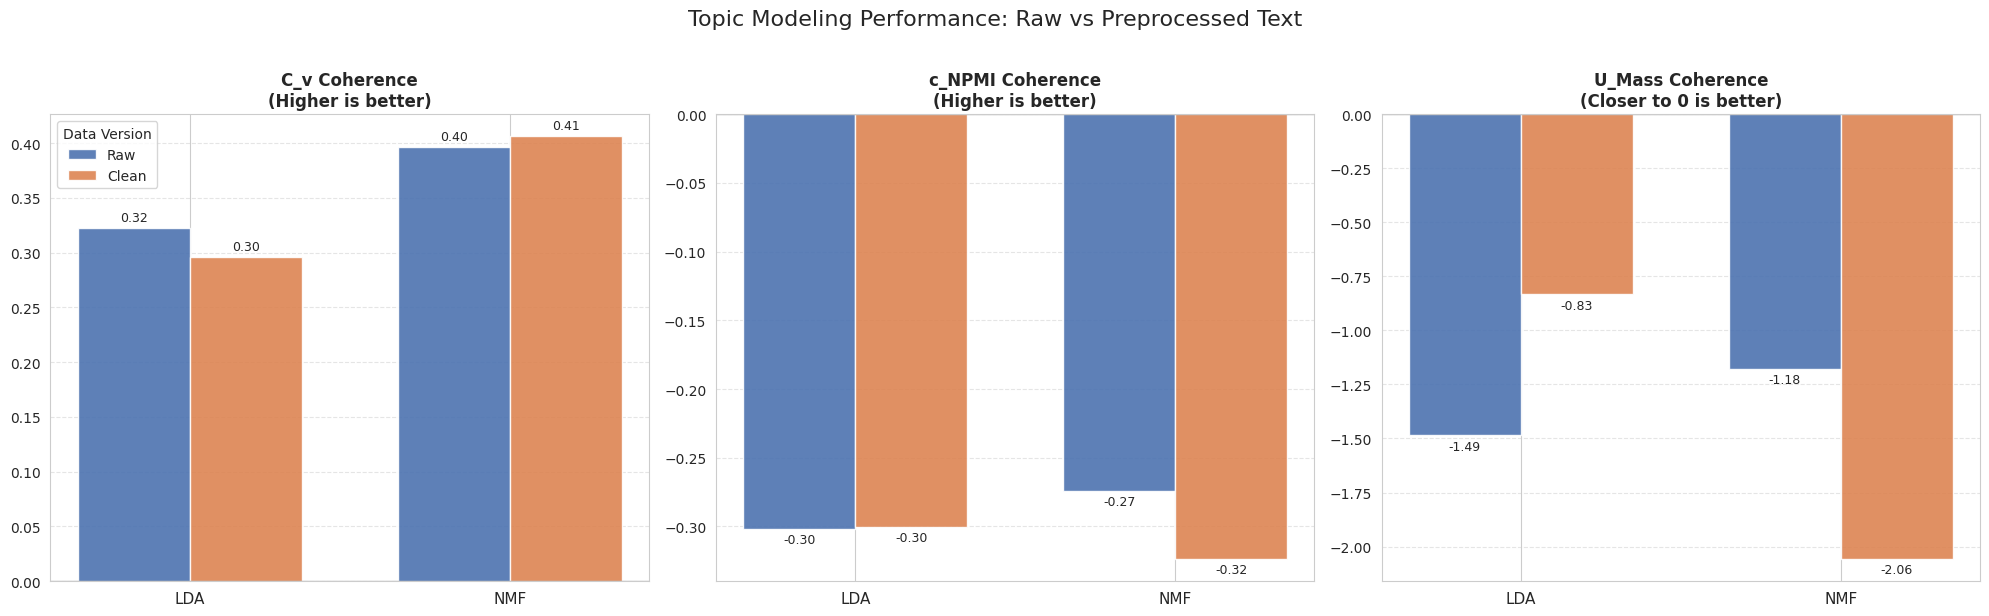


Visualizing Top Words for NMF (Clean Data)


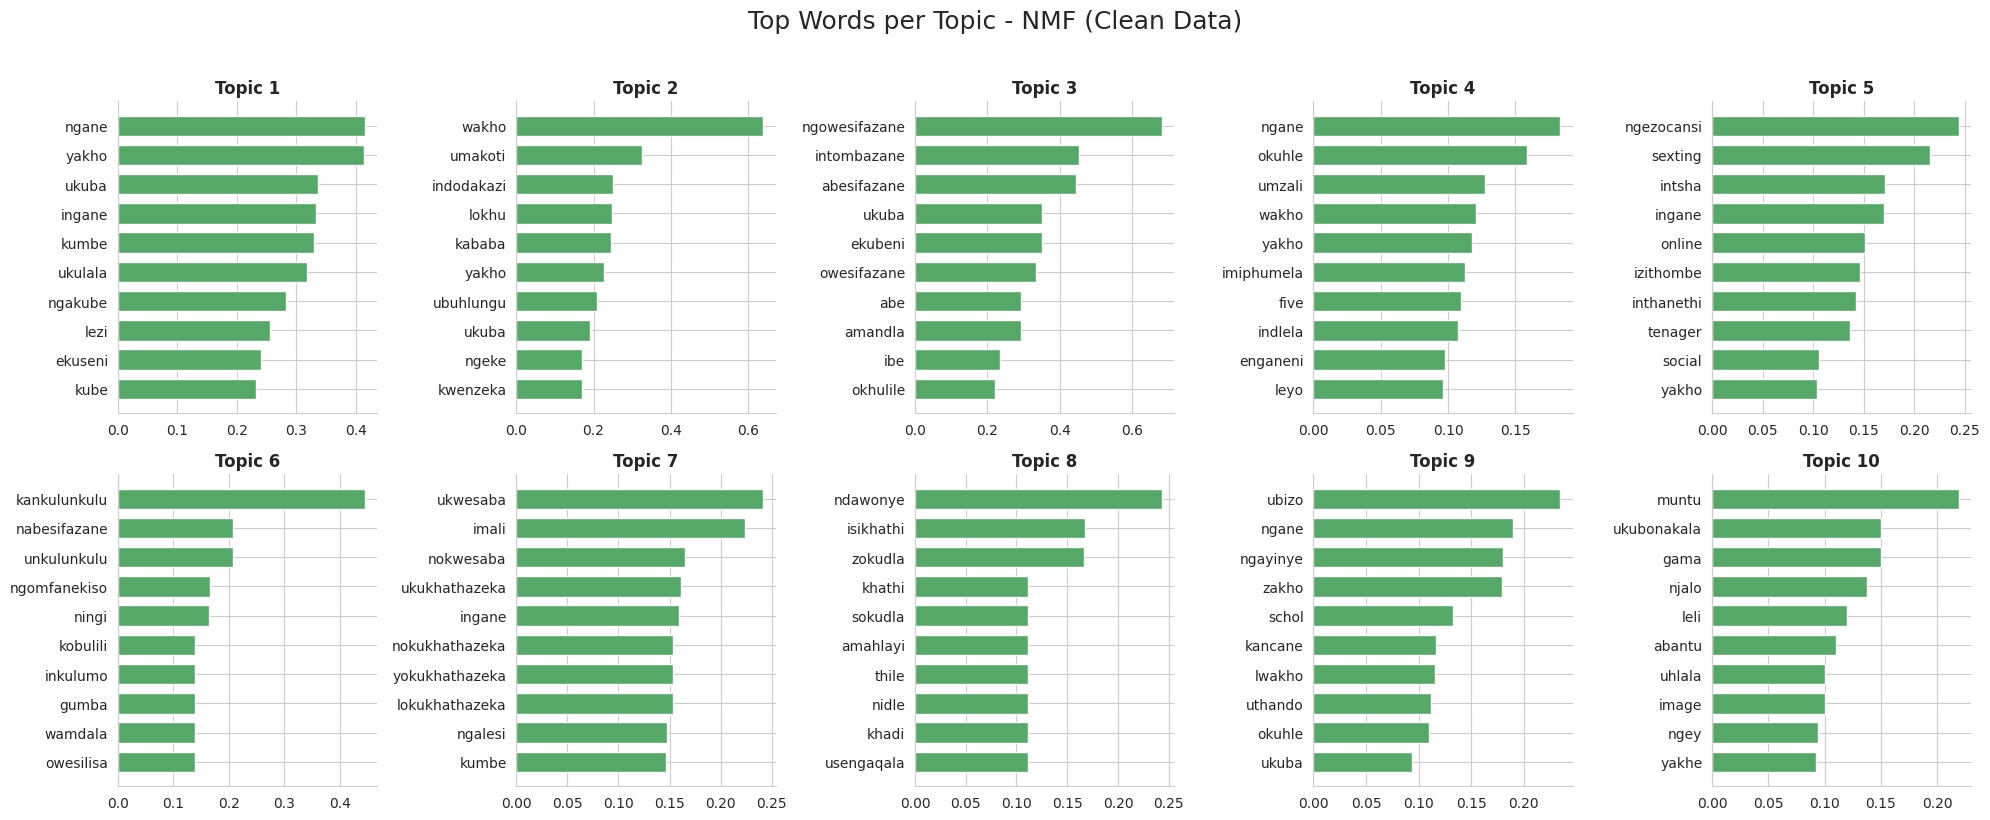

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ==========================================
# Part 1: Plot Coherence Scores (Bar Charts)
# ==========================================

# Retrieve the comparison DataFrame from your results
df_viz = podcast_topic_results['comparison_df'].copy()

# Set up the figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Topic Modeling Performance: Raw vs Preprocessed Text', fontsize=16, y=1.02)

# Define metrics and their display titles
metrics = [
    ('c_v', 'C_v Coherence\n(Higher is better)'),
    ('c_npmi', 'c_NPMI Coherence\n(Higher is better)'),
    ('u_mass', 'U_Mass Coherence\n(Closer to 0 is better)')
]

# Visual settings
colors = {'Raw': '#4c72b0', 'Clean': '#dd8452'} # Blue and Orange
x = np.arange(len(df_viz['model']))  # label locations
width = 0.35  # width of the bars

for i, (metric_base, title) in enumerate(metrics):
    ax = axes[i]

    # Extract data for this metric
    raw_vals = df_viz[f'{metric_base}_raw']
    clean_vals = df_viz[f'{metric_base}_clean']

    # Create grouped bars
    rects1 = ax.bar(x - width/2, raw_vals, width, label='Raw', color=colors['Raw'], alpha=0.9)
    rects2 = ax.bar(x + width/2, clean_vals, width, label='Clean', color=colors['Clean'], alpha=0.9)

    # Formatting
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_viz['model'], fontsize=11)

    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax.legend(title="Data Version")

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linewidth=0.8) # Zero line for reference

    # Add value labels on top of bars
    ax.bar_label(rects1, padding=3, fmt='%.2f', fontsize=9)
    ax.bar_label(rects2, padding=3, fmt='%.2f', fontsize=9)

plt.tight_layout()
plt.show()

# ==========================================
# Part 2: Visualize Top Words for Best Model
# ==========================================

def plot_top_words_weights(model, feature_names, n_top_words=10, title="Top Words"):
    """Generates horizontal bar charts for the top words in each topic."""
    n_topics = len(model.components_)
    rows = int(np.ceil(n_topics / 5))
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows), sharex=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        # Get top words and their weights
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]

        # Plot
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='#55a868')
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.invert_yaxis() # Highest weight at top
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Remove distinct spines for cleaner look
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    # Hide unused subplots
    for i in range(topic_idx + 1, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# Example: Plotting for NMF (Clean Data) as it often yields distinct topics
print("\n" + "="*50)
print("Visualizing Top Words for NMF (Clean Data)")
print("="*50)

nmf_data = podcast_topic_results['clean']['nmf']
plot_top_words_weights(
    nmf_data['model'],
    nmf_data['vectorizer'].get_feature_names_out(),
    title="Top Words per Topic - NMF (Clean Data)"
)

In [ ]:
print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80 + "\n")

print(f"Results saved to: {CONFIG['output_dir']}/")
print("\nFiles created:")
print("  Lwazi:")
print("    - lwazi_zulu_raw.pkl")
print("    - lwazi_zulu_clean.pkl")
print("    - lwazi_zulu_comparison.csv")
print("    - lwazi_zulu_transcriptions.csv")
print("\n  Podcast:")
print("    - podcast_ezomndeni_raw.pkl")
print("    - podcast_ezomndeni_clean.pkl")
print("    - podcast_ezomndeni_comparison.csv")
print("    - podcast_ezomndeni_transcriptions.csv")

print("\n✓ All done!")